# Import Necessary Headers

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Load Updated CSV into Pandas Dataframe

In [2]:
df = pd.read_csv("hong_et_al/df_updt.csv")

In [3]:
# Initial view of the frame
df.head(3)

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4.0,40.0,Male,Hispanic or Latino,White or Caucasian,English,NaN,Single,Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B,4.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocess Data

In [4]:
# Drop CKD information columns
df = df.drop(columns=df.filter(like='chrkidneydisease').columns)

# Exclude columns describing direct parameter to CKD-EPI Creatinine Equation used to calculate eGFR
df = df.drop(columns=df.filter(like='creat').columns)

# Drop rows with NaN eGFR values
df.dropna(subset=['egfr_CKD_EPI'])

# Impute median data for any remaining NaN values in numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Cast categorical columns as type category
categorical_cols = ['dep_name', 'gender', 'ethnicity', 'race', 'lang', 'religion',
                    'maritalstatus', 'employstatus', 'insurance_status', 'disposition', 'arrivalmode',
                    'arrivalmonth', 'arrivalday', 'arrivalhour_bin', 'previousdispo']

df[categorical_cols] = df[categorical_cols].astype('category')

# Define Train and Test Data Sets

In [5]:
# Exclude target variable from features frame
X = df.drop(columns=df.filter(like='egfr').columns)

# Set target variable to egfr_CKD_EPI; calculated patient eGFR 
y = df['egfr_CKD_EPI']

def create_splits(X, y, test_size=0.1, val_size=0.2, n_splits=5, seed=42):
    np.random.seed(seed)  # Ensure reproducibility
    
    # Step 1: Split data into test and the remaining data
    X_traindev, X_test, y_traindev, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # Step 2: Further split the remaining data into multiple train and validation sets
    val_sets = []
    for _ in range(n_splits):
        # Randomly select validation set from the remaining data
        X_train, X_val, y_train, y_val = train_test_split(X_traindev, y_traindev, test_size=val_size, random_state=np.random.randint(10000))
        
        val_sets.append({
            'X_train': X_train, 
            'y_train': y_train, 
            'X_val': X_val, 
            'y_val': y_val
        })

    return X_traindev, y_traindev, X_test, y_test, val_sets

X_traindev, y_traindev, X_test, y_test, val_sets = create_splits(X, y)

# Initialize XGBoost Regressor Model

In [7]:
# Initialize your model
model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0, enable_categorical=True)

# GridSearch Hyperparameter Optimization

# Bayesian Hyperparameter Optimization

In [8]:
def evaluate_on_val_sets(model, params, val_sets):
    mse_scores = []
    for val in val_sets:
        # Set parameters and reinitialize the model to avoid leakage from previous fits
        model.set_params(**params)
        model.fit(val['X_train'], val['y_train'])

        try:
            # Predict on the validation set and calculate MSE
            preds = model.predict(val['X_val'])
            mse = mean_squared_error(val['y_val'], preds)
        except Exception as e:
            print(f"Error during model prediction: {str(e)}")
            mse = float('inf')  # Consider the worst case if prediction fails

        mse_scores.append(mse)
    
    # Calculate average MSE across all validation sets
    return np.mean(mse_scores)

In [9]:
# Define the search space
space = [
    Integer(5, 20, name='max_depth'),
    Integer(1, 10, name='min_child_weight'),
    Real(0.5, 5.0, name='gamma'),
    Real(0.6, 1.0, name='subsample'),
    Real(0.6, 1.0, name='colsample_bytree'),
    Real(0.01, 0.3, name='learning_rate'),
    Integer(50, 300, name='n_estimators')
]

# Define objective function
@use_named_args(space)
def objective(**params):
    print("Testing params:", params)  # Debug: print parameters to console
    mse = evaluate_on_val_sets(model, params, val_sets)
    print("MSE for params:", mse)  # Debug: print result to console
    return mse

# Perform Bayesian Optimization
result = gp_minimize(objective, space, n_calls=10, random_state=42)


# Extract the best parameters and the corresponding score
best_params = {dimension.name: result.x[i] for i, dimension in enumerate(space)}
best_score = result.fun

print("Best parameters found: ", best_params)
print("Best average MSE across validation sets: ", best_score)

Testing params: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 4.008609501227463, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'learning_rate': 0.03899272558722084, 'n_estimators': 165}
MSE for params: 79.56510509045893
Testing params: {'max_depth': 5, 'min_child_weight': 2, 'gamma': 3.4289981282698383, 'subsample': 0.6225646316108401, 'colsample_bytree': 0.88879950890673, 'learning_rate': 0.2821802856145676, 'n_estimators': 50}
MSE for params: 93.05953569987983
Testing params: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 3.2524392221972644, 'subsample': 0.6028265220878869, 'colsample_bytree': 0.6092249700165663, 'learning_rate': 0.16218465147493288, 'n_estimators': 150}
MSE for params: 72.92275977378634
Testing params: {'max_depth': 3, 'min_child_weight': 10, 'gamma': 1.5474710319363694, 'subsample': 0.6362425738131283, 'colsample_bytree': 0.847354403733235, 'learning_rate': 0.12091397746747722, 'n_estimators': 296}
MSE for params: 94.65331144345289


# Train XG Boost Regressor on Full Training Set

In [11]:
model.set_params(**best_params)
# Assuming you combine all training data or select a larger subset
model.fit(X_traindev, y_traindev)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6092249700165663, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=3.2524392221972644,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16218465147493288,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluate Feature Importance

In [12]:
# Retrieve feature importances
importances = model.feature_importances_

# Create a frame for feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance frame
print(feature_importance.head(30))

                           Feature  Importance
315                       bun_last    0.128019
397                        bun_min    0.050910
622          troponini(poc)_median    0.017191
2                              age    0.016195
479                        bun_max    0.013347
524                     pocbun_max    0.011166
5                             race    0.009064
724  meds_colonystimulatingfactors    0.007737
138                            htn    0.007155
561                     bun_median    0.005684
459                  troponint_min    0.005619
10                insurance_status    0.005490
196                     otdxkidney    0.004764
22                      acrenlfail    0.004550
3                           gender    0.004337
541                  troponint_max    0.004327
376            troponini(poc)_last    0.004138
650               pregtestur_count    0.003967
61                        chfnonhp    0.003605
330                   glucose_last    0.003544
235          

# Visualize Feature Importance

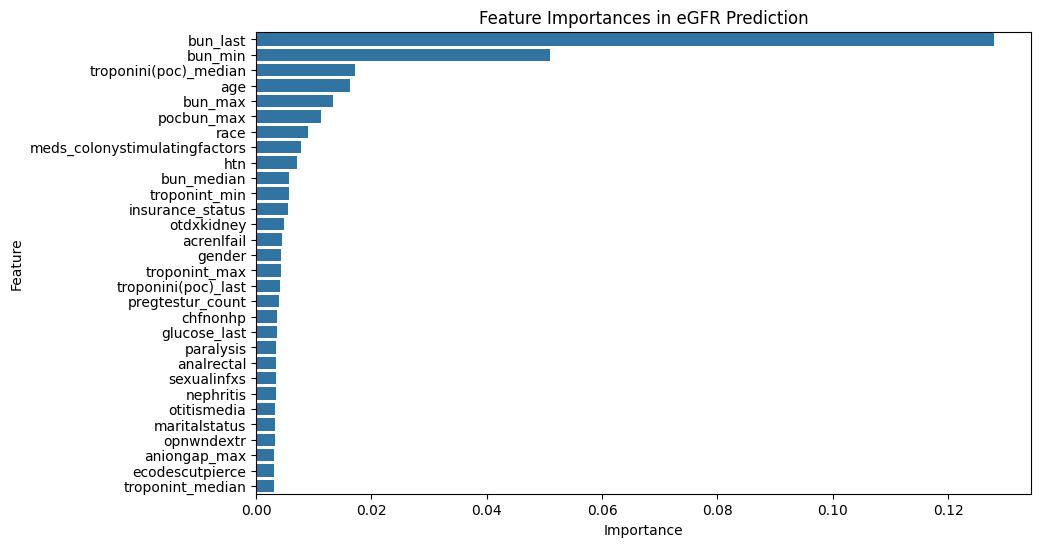

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(30))
plt.title('Feature Importances in eGFR Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()